# Import the libraries used

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.stattools import acf
import seaborn as sns
import missingno as msno

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

# from statsmodels.graphics.tsaplots import plot_acf

# plt.style.use('dark_background')

In [2]:
# To comment if you're running on Colab
data_path = Path('Data/')
data_path

PosixPath('Data')

In [3]:
# To comment if you're running locally
# !git clone https://github.com/FabioLddo/time_series_energy_community_forecasting.git
# data_path = Path('time_series_energy_community_forecasting/Data/')

# Import the data

In [4]:
# Import lic_meteo file
df_meteo = pd.read_pickle(Path(data_path, 'ec_meteo/lic_meteo'))
df_meteo.head()

,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,Ramount_Tot,RelHumidity,WindSpeed
2020-01-01 00:00:00+00:00,965.453333,5.613533,-2.768667,0.0,48.806667,0.617600
2020-01-01 00:15:00+00:00,965.460000,5.544867,-2.425200,0.0,49.060000,1.238600
2020-01-01 00:30:00+00:00,965.353333,5.549267,-2.498133,0.0,48.820000,0.854533
2020-01-01 00:45:00+00:00,965.320000,5.639200,-2.406067,0.0,49.093333,0.923733
2020-01-01 01:00:00+00:00,965.300000,6.030800,-2.363267,0.0,47.546667,0.916733


In [5]:
# Import lic_meters file
df_meters = pd.read_pickle(Path(data_path, 'ec_meters/lic_meters'))
df_meters.head()

0            1            2            3        \
                           e_pos e_neg  e_pos e_neg  e_pos e_neg  e_pos e_neg   
2020-12-31 23:00:00+00:00  126.0   0.0  974.0   0.0  544.0   0.0  681.0   0.0   
2020-12-31 23:15:00+00:00  102.0   0.0  211.0   0.0  495.0   0.0  606.0   0.0   
2020-12-31 23:30:00+00:00  121.0   0.0  210.0   0.0  233.0   0.0  598.0   0.0   
2020-12-31 23:45:00+00:00   98.0   0.0  291.0   0.0  449.0   0.0  624.0   0.0   
2021-01-01 00:00:00+00:00  131.0   0.0  533.0   0.0  507.0   0.0  547.0   0.0   

                                    4        ...      17           18        \
                                e_pos e_neg  ...   e_pos e_neg  e_pos e_neg   
2020-12-31 23:00:00+00:00  142.000000   0.0  ...   670.0   0.0  808.0   0.0   
2020-12-31 23:15:00+00:00  663.000000   0.0  ...   525.0   0.0  513.0   0.0   
2020-12-31 23:30:00+00:00  437.167377   0.0  ...   499.0   0.0  436.0   0.0   
2020-12-31 23:45:00+00:00  386.815026   0.0  ...   695.0   0.0  362.0   0.0   
2021-01-01 00:00:00+00:00  390.256124   0.0  ...  1109.0   0.0  504.0   0.0   

                               19       battery            PCC        
                            e_pos e_neg   e_pos e_neg    e_pos e_neg  
2020-12-31 23:00:00+00:00  1805.0   0.0     1.0   0.0   9142.0   0.0  
2020-12-31 23:15:00+00:00  3082.0   0.0     0.0   0.0  13330.0   0.0  
2020-12-31 23:30:00+00:00   881.0   0.0     1.0   0.0   9095.0   0.0  
2020-12-31 23:45:00+00:00   659.0   0.0     1.0   0.0   9380.0   0.0  
2021-01-01 00:00:00+00:00  2384.0   0.0     0.0   0.0  11750.0   0.0  

[5 rows x 44 columns]

In [103]:
# Import lic_nwp file
df_nwp = pd.read_pickle(Path(data_path, 'ec_nwp/lic_nwp'))
start_date = '2021-01-01 00:00:00+00:00'

end_date = '2022-12-29 22:00:00+00:00'

df_nwp = df_nwp.loc[start_date:end_date]

In [86]:
sorted_nwp = df_nwp.sort_index(axis=1, level=[0, 1])
sorted_nwp

ghi_backwards                                     \
                                    0    1    2    3    4    5    6    7     
2021-01-01 00:00:00+00:00           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2021-01-02 00:00:00+00:00           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2021-01-03 00:00:00+00:00           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2021-01-04 00:00:00+00:00           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2021-01-05 00:00:00+00:00           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
...                                 ...  ...  ...  ...  ...  ...  ...  ...   
2022-12-25 00:00:00+00:00           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-12-26 00:00:00+00:00           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-12-27 00:00:00+00:00           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-12-28 00:00:00+00:00           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2022-12-29 00:00:00+00:00           0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                                          ... temperature                    \
                             8       9    ...         159   160   161   162   
2021-01-01 00:00:00+00:00  13.60   45.82  ...        3.91  2.65  1.47  0.46   
2021-01-02 00:00:00+00:00  12.95   54.19  ...        2.79  1.40  0.20 -0.97   
2021-01-03 00:00:00+00:00   6.86    5.70  ...        3.67  2.91  2.34  1.89   
2021-01-04 00:00:00+00:00  17.30   54.18  ...        2.46  0.96 -0.32 -1.36   
2021-01-05 00:00:00+00:00  14.20   30.61  ...        2.34  1.37  0.57 -0.14   
...                          ...     ...  ...         ...   ...   ...   ...   
2022-12-25 00:00:00+00:00  43.60  113.59  ...        7.78  7.05  6.38  5.80   
2022-12-26 00:00:00+00:00  31.58   83.21  ...        9.50  8.59  7.75  7.13   
2022-12-27 00:00:00+00:00  56.29  188.88  ...        9.07  8.39  7.82  7.42   
2022-12-28 00:00:00+00:00  29.09   78.56  ...        8.66  7.88  7.46  7.25   
2022-12-29 00:00:00+00:00  37.02  108.91  ...        9.67  8.78  7.96  7.28   

                                                               
                            163   164   165   166   167   168  
2021-01-01 00:00:00+00:00 -0.31 -0.74 -0.97 -1.27 -1.62 -1.85  
2021-01-02 00:00:00+00:00 -1.91 -2.71 -3.38 -4.05 -3.93 -3.54  
2021-01-03 00:00:00+00:00  1.57  1.34  1.09  0.76  0.35 -0.24  
2021-01-04 00:00:00+00:00 -2.22 -2.91 -3.49 -4.03 -3.90 -3.58  
2021-01-05 00:00:00+00:00 -0.76 -1.27 -1.70 -2.04 -2.38 -2.52  
...                         ...   ...   ...   ...   ...   ...  
2022-12-25 00:00:00+00:00  5.27  4.77  4.28  3.78  3.78  3.85  
2022-12-26 00:00:00+00:00  6.73  6.50  6.34  6.20  6.02  5.82  
2022-12-27 00:00:00+00:00  7.17  7.02  6.90  6.83  6.76  6.73  
2022-12-28 00:00:00+00:00  7.11  7.04  6.85  6.79  6.67  6.55  
2022-12-29 00:00:00+00:00  6.75  6.28  5.79  5.21  4.94  4.58  

[1358 rows x 507 columns]

In [87]:
ghi_backwards_df = sorted_nwp['ghi_backwards']
temperature_df = sorted_nwp['temperature']

In [123]:
# create df with hourly index from start to end date and 24 columns with nan values
hourly_temperature_df = pd.DataFrame(index=pd.date_range(start=start_date, end=end_date, freq='H'),
                                columns=range(24))


In [124]:
hourly_temperature_df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
2021-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 03:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-29 18:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-29 19:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-29 20:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-29 21:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [125]:
temperature_df.loc[temperature_df.index <= target_date].iloc[-1,:24].values

array([28.33, 28.67, 29.  , 28.67, 27.33, 25.33, 23.2 , 21.6 , 20.45,
       19.41, 18.6 , 18.15, 19.  , 18.41, 17.64, 17.22, 17.23, 18.28,
       19.95, 21.82, 23.46, 25.17, 26.58, 27.72])

In [126]:

# iterate over rows index of temperature df
for i in range(10):# len(hourly_temperature_df)
    time = hourly_temperature_df.index[i]
    preds_row = temperature_df.loc[temperature_df.index <= time].iloc[-1]
    delta = time - preds_row.name  
    hours_diff = delta.total_seconds() / 3600
    print(hours_diff)
    hourly_temperature_df.iloc[i] = temperature_df.loc[temperature_df.index <= time].iloc[-1, int(hours_diff):24 + int(hours_diff)].values

0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0


In [127]:
# create df with hourly index from start to end date and 24 columns with nan values
hourly_temperature_df = pd.DataFrame(index=pd.date_range(start=start_date, end=end_date, freq='H'),
                                columns=range(24))


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
2021-01-01 00:00:00+00:00,3.0,2.97,3.0,2.97,2.7,2.0,1.03,0.67,0.33,0.33,...,0.33,0.0,0.0,0.07,0.22,0.38,0.55,0.64,0.78,0.65
2021-01-01 01:00:00+00:00,2.97,3.0,2.97,2.7,2.0,1.03,0.67,0.33,0.33,0.0,...,0.0,0.0,0.07,0.22,0.38,0.55,0.64,0.78,0.65,0.33
2021-01-01 02:00:00+00:00,3.0,2.97,2.7,2.0,1.03,0.67,0.33,0.33,0.0,0.0,...,0.0,0.07,0.22,0.38,0.55,0.64,0.78,0.65,0.33,0.1
2021-01-01 03:00:00+00:00,2.97,2.7,2.0,1.03,0.67,0.33,0.33,0.0,0.0,0.33,...,0.07,0.22,0.38,0.55,0.64,0.78,0.65,0.33,0.1,0.39
2021-01-01 04:00:00+00:00,2.7,2.0,1.03,0.67,0.33,0.33,0.0,0.0,0.33,0.33,...,0.22,0.38,0.55,0.64,0.78,0.65,0.33,0.1,0.39,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-29 18:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-29 19:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-29 20:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-29 21:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
hourly_temperature_df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
2021-01-01 00:00:00+00:00,3.0,2.97,3.0,2.97,2.7,2.0,1.03,0.67,0.33,0.33,...,0.33,0.0,0.0,0.07,0.22,0.38,0.55,0.64,0.78,0.65
2021-01-01 01:00:00+00:00,2.97,3.0,2.97,2.7,2.0,1.03,0.67,0.33,0.33,0.0,...,0.0,0.0,0.07,0.22,0.38,0.55,0.64,0.78,0.65,0.33
2021-01-01 02:00:00+00:00,3.0,2.97,2.7,2.0,1.03,0.67,0.33,0.33,0.0,0.0,...,0.0,0.07,0.22,0.38,0.55,0.64,0.78,0.65,0.33,0.1
2021-01-01 03:00:00+00:00,2.97,2.7,2.0,1.03,0.67,0.33,0.33,0.0,0.0,0.33,...,0.07,0.22,0.38,0.55,0.64,0.78,0.65,0.33,0.1,0.39
2021-01-01 04:00:00+00:00,2.7,2.0,1.03,0.67,0.33,0.33,0.0,0.0,0.33,0.33,...,0.22,0.38,0.55,0.64,0.78,0.65,0.33,0.1,0.39,0.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-29 18:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-29 19:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-29 20:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-29 21:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
hours_diff].values

In [66]:
import pandas as pd

# Read the original dataset
orig_data = df_nwp

# Create an empty DataFrame to store the transformed data
transformed_data = pd.DataFrame()

# Loop through the rows of the original dataset, except the last one
for i in range(len(orig_data) - 1):
    # Extract the first 12 hours of forecast data
    first_12_hours = orig_data.iloc[i, :12]

    # Extract the next 12 hours of forecast data from the next row
    next_12_hours = orig_data.iloc[i + 1, :12]

    # Combine the data and append it as a new row in the transformed DataFrame
    combined_data = pd.concat([first_12_hours, next_12_hours])
    transformed_data = transformed_data.append(combined_data, ignore_index=True)

# Save the transformed data to a new CSV file


/tmp/ipykernel_13961/1529816783.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transformed_data = transformed_data.append(combined_data, ignore_index=True)
/tmp/ipykernel_13961/1529816783.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transformed_data = transformed_data.append(combined_data, ignore_index=True)
/tmp/ipykernel_13961/1529816783.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transformed_data = transformed_data.append(combined_data, ignore_index=True)
/tmp/ipykernel_13961/1529816783.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  transformed_data = transformed_data.append(combined_data, ignore_index=Tr

ghi_backwards                                                          \
               0       1       10     100  101  102    103     104     105   
0             0.00    0.00  273.43   0.00  0.0  0.0   0.00   26.58  127.41   
1           354.10  314.48    0.00  33.83  0.0  0.0   0.00    0.00    0.00   
2             0.00    0.00  265.03   0.00  0.0  0.0   0.00   25.69  124.16   
3           345.37  307.64    0.00  34.66  0.0  0.0   0.00    0.00    0.00   
4             0.00    0.00   60.56   0.00  0.0  0.0   0.00   25.68  121.78   
...            ...     ...     ...    ...  ...  ...    ...     ...     ...   
2018          0.00    0.00  445.91   0.00  0.0  0.0  12.62   98.78  222.75   
2019          0.00    0.00  344.87   0.00  0.0  0.0   6.53   41.74   86.72   
2020          0.00    0.00  189.44   0.00  0.0  0.0   7.78   47.06   99.28   
2021          0.00    0.00  452.66   0.00  0.0  0.0  20.73  137.38  297.33   
2022          0.00    0.00  132.73   0.00  0.0  0.0  16.48  107.13  231.32   

              ...                                                          \
         106  ...     10     100  101  102    103     104     105     106   
0     234.86  ...    0.00  33.83  0.0  0.0   0.00    0.00    0.00    0.00   
1       0.00  ...  265.03   0.00  0.0  0.0   0.00   25.69  124.16  229.88   
2     229.88  ...    0.00  34.66  0.0  0.0   0.00    0.00    0.00    0.00   
3       0.00  ...   60.56   0.00  0.0  0.0   0.00   25.68  121.78  221.89   
4     221.89  ...    0.00  33.64  0.0  0.0   0.00    0.00    0.00    0.00   
...      ...  ...     ...    ...  ...  ...    ...     ...     ...     ...   
2018  295.03  ...  344.87   0.00  0.0  0.0   6.53   41.74   86.72  123.88   
2019  123.88  ...  189.44   0.00  0.0  0.0   7.78   47.06   99.28  163.44   
2020  163.44  ...  452.66   0.00  0.0  0.0  20.73  137.38  297.33  435.27   
2021  435.27  ...  132.73   0.00  0.0  0.0  16.48  107.13  231.32  339.49   
2022  339.49  ...  420.29   0.00  0.0  0.0  15.24   82.81  168.08  234.96   

                      
         107     108  
0       0.00    0.00  
1     303.08  332.77  
2       0.00    0.00  
3     286.39  304.85  
4       0.00    0.00  
...      ...     ...  
2018  146.48  154.62  
2019  229.88  281.69  
2020  523.93  554.43  
2021  415.56  447.03  
2022  277.81  292.07  

[2023 rows x 24 columns]

Check columns of the 3 datasets

In [7]:
# Check df_meteo columns
df_meteo.columns

Index(['AirPressure', 'AirTemp_Avg', 'PyrIrradiance_Avg', 'Ramount_Tot',
       'RelHumidity', 'WindSpeed'],
      dtype='object')

In [8]:
# Check df_meters columns
df_meters.columns

MultiIndex([(        0, 'e_pos'),
            (        0, 'e_neg'),
            (        1, 'e_pos'),
            (        1, 'e_neg'),
            (        2, 'e_pos'),
            (        2, 'e_neg'),
            (        3, 'e_pos'),
            (        3, 'e_neg'),
            (        4, 'e_pos'),
            (        4, 'e_neg'),
            (        5, 'e_pos'),
            (        5, 'e_neg'),
            (        6, 'e_pos'),
            (        6, 'e_neg'),
            (        7, 'e_pos'),
            (        7, 'e_neg'),
            (        8, 'e_pos'),
            (        8, 'e_neg'),
            (        9, 'e_pos'),
            (        9, 'e_neg'),
            (       10, 'e_pos'),
            (       10, 'e_neg'),
            (       11, 'e_pos'),
            (       11, 'e_neg'),
            (       12, 'e_pos'),
            (       12, 'e_neg'),
            (       13, 'e_pos'),
            (       13, 'e_neg'),
            (       14, 'e_pos'),
            ( 

In [9]:
# Check df_nwp columns
df_nwp.columns

MultiIndex([('ghi_backwards',   0),
            ('ghi_backwards',   1),
            ('ghi_backwards',  10),
            ('ghi_backwards', 100),
            ('ghi_backwards', 101),
            ('ghi_backwards', 102),
            ('ghi_backwards', 103),
            ('ghi_backwards', 104),
            ('ghi_backwards', 105),
            ('ghi_backwards', 106),
            ...
            (  'temperature',  90),
            (  'temperature',  91),
            (  'temperature',  92),
            (  'temperature',  93),
            (  'temperature',  94),
            (  'temperature',  95),
            (  'temperature',  96),
            (  'temperature',  97),
            (  'temperature',  98),
            (  'temperature',  99)],
           length=507)

Get rid of MultiIndex in df_meters and df_nwp

In [10]:
# Get rid of the MultiIndex in df_meters
# df_meters.columns = df_meters.columns.droplevel(0)
# df_meters.columns

In [11]:
# Get rid of the MultiIndex in df_nwp
# df_nwp.columns = df_nwp.columns.droplevel(1)
# df_nwp.columns

# Exploratory Data Analysis

Visualize the data in df_meteo

<Axes: >

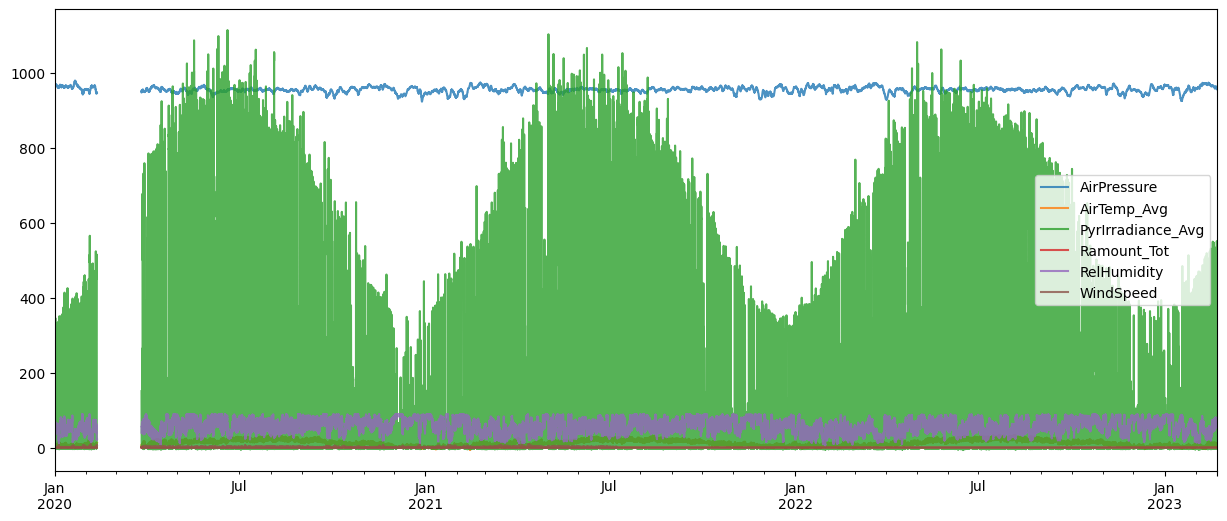

In [12]:
df_meteo.plot(figsize=(15, 6), alpha=0.8)

Visualize the data in df_meters

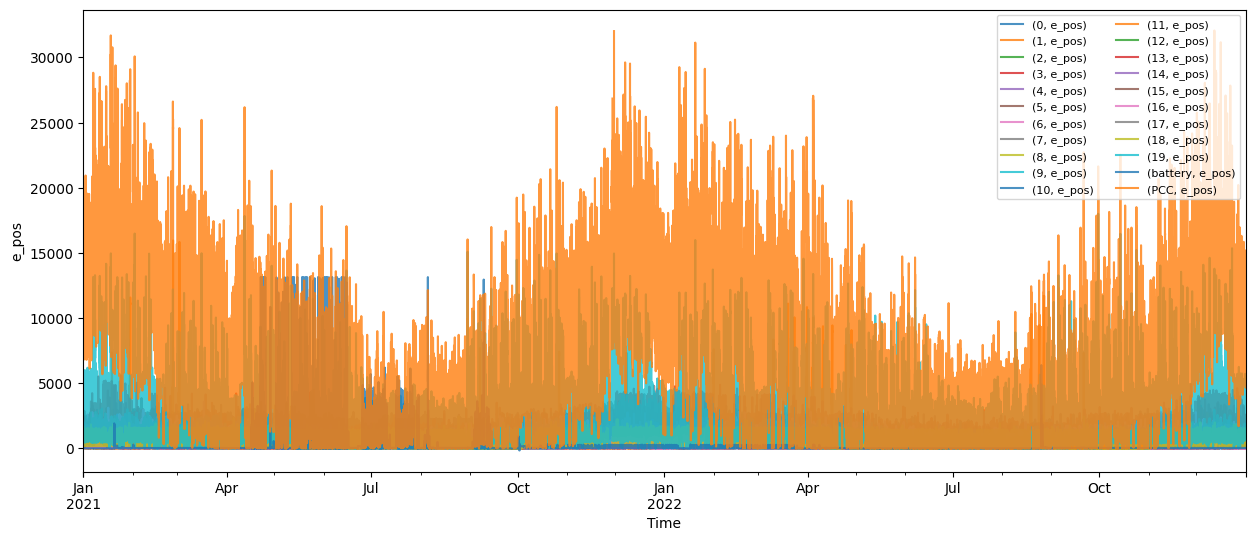

In [13]:
# Plot the e_pos measure in the df_meters dataset
e_pos_cols = [col for col in df_meters.columns if 'e_pos' in col]

# Plot the e_pos columns against the DataFrame's index
df_meters[e_pos_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('e_pos')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

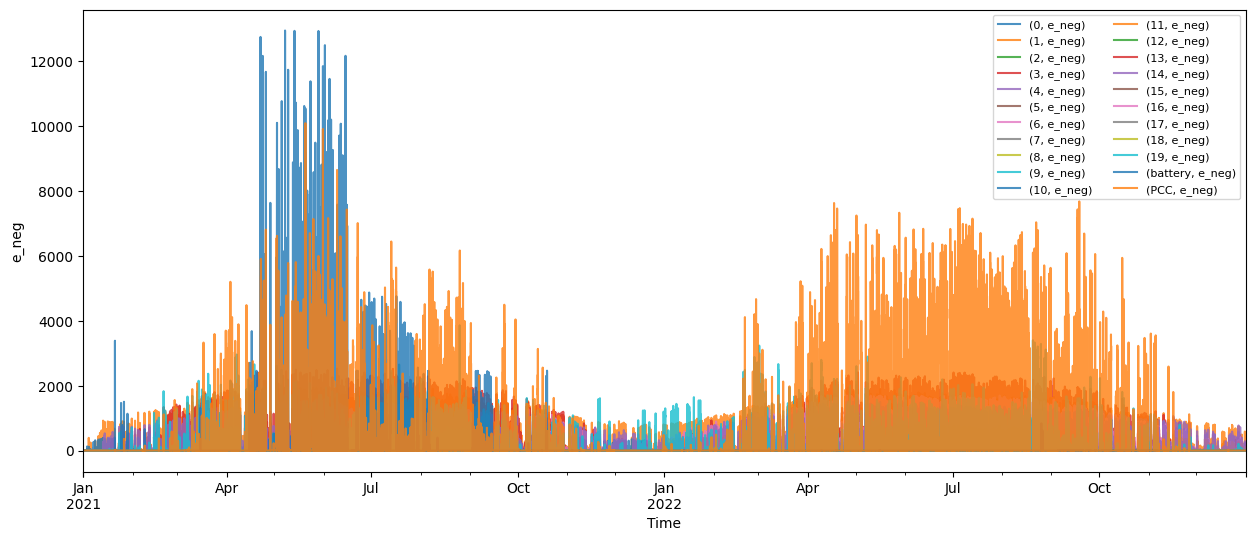

In [14]:
# Plot the e_neg measure in the df_meters dataset
e_neg_cols = [col for col in df_meters.columns if 'e_neg' in col]

# Plot the e_neg columns against the DataFrame's index
df_meters[e_neg_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('e_neg')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

Visualize the data in df_nwp

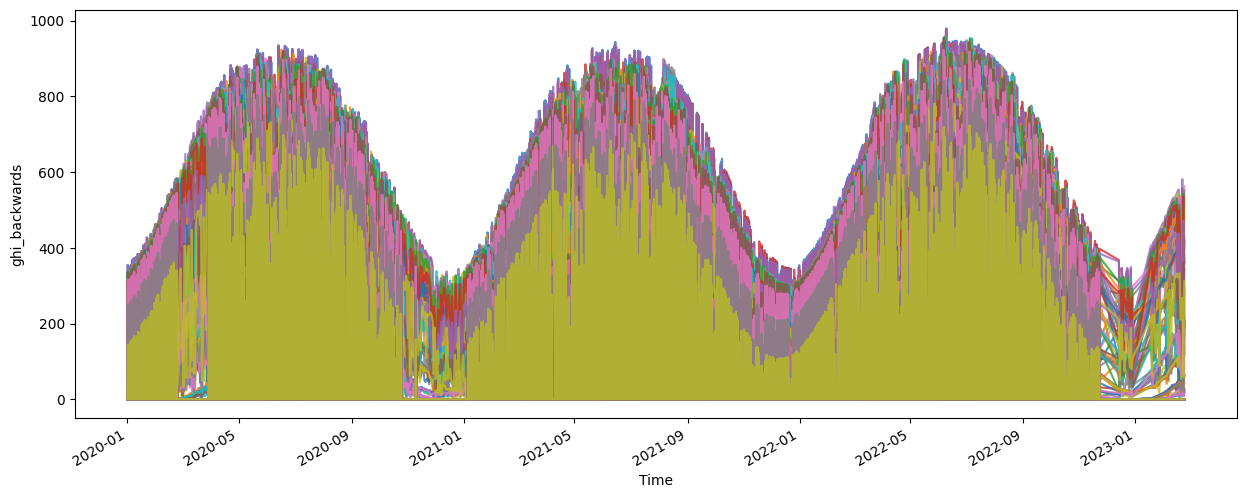

In [15]:
# Plot the ghi_backwards measure in the df_nwp dataset
e_ghi_cols = [col for col in df_nwp.columns if 'ghi_backwards' in col]

# Plot the ghi_backwards columns against the DataFrame's index
df_nwp[e_ghi_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('ghi_backwards')
plt.legend('', frameon=False)
# plt.legend(loc='upper right', ncol=2, fontsize=8)  # Comment label due to size reasons
plt.show()

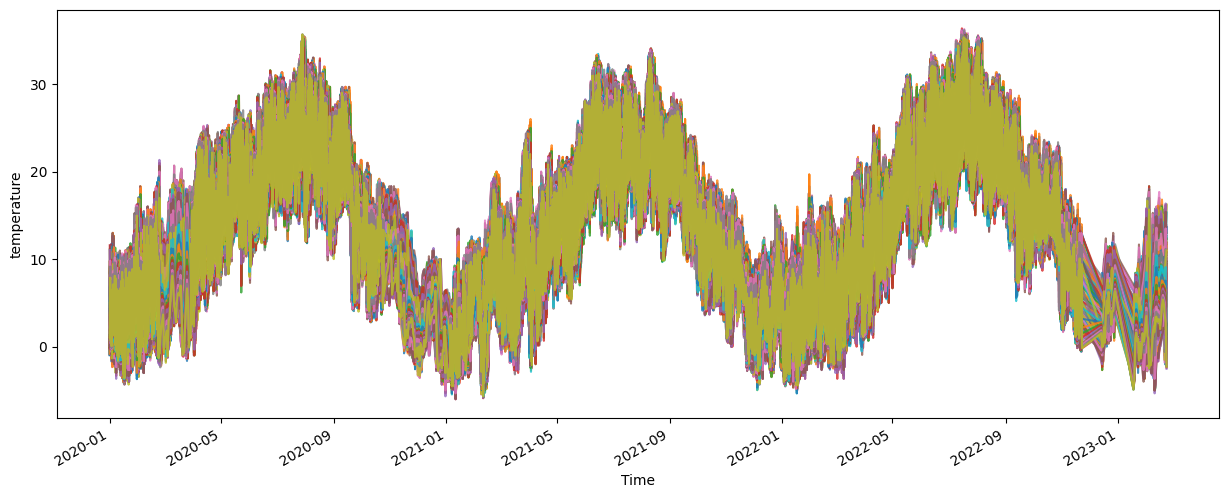

In [16]:
# Plot the temperature measure in the df_nwp dataset
e_temp_cols = [col for col in df_nwp.columns if 'temperature' in col]

# Plot the temperature columns against the DataFrame's index
df_nwp[e_temp_cols].plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('temperature')
plt.legend('', frameon=False)
# plt.legend(loc='upper right', ncol=2, fontsize=8)  # Comment label due to size reasons
plt.show()

In [17]:
df_nwp.columns
# df_nwp.save(Path(data_path, 'nwp.csv'))
df_nwp.to_csv(Path(data_path, 'nwp.csv'))

In [18]:
len(df_nwp.columns)

507

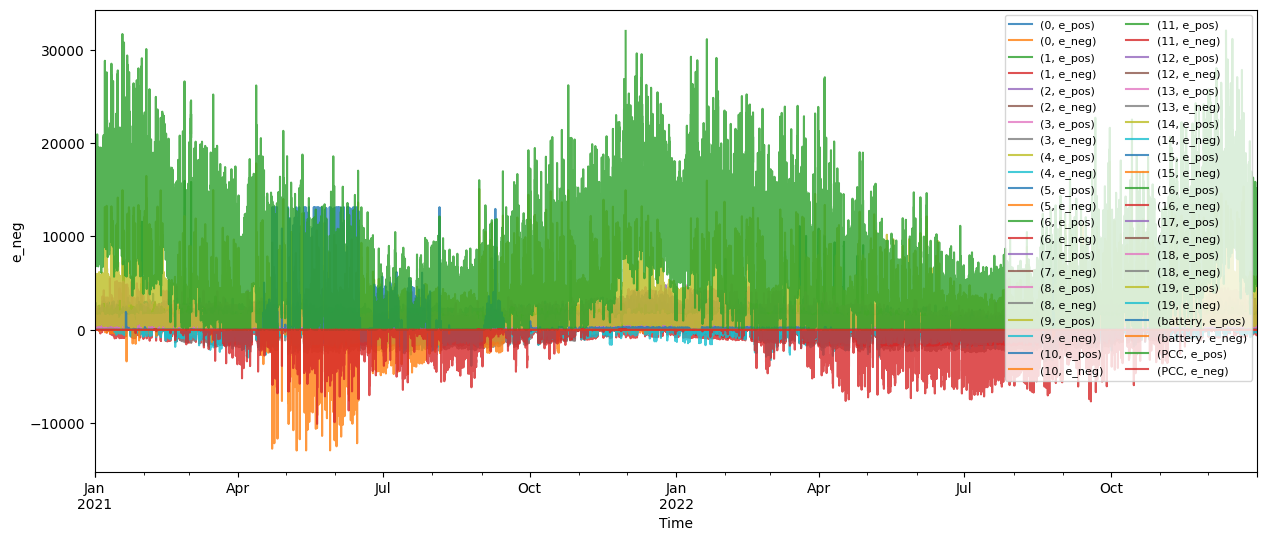

In [19]:
df = df_meters.copy()
df[e_neg_cols] = -df[e_neg_cols]

df.plot(figsize=(15, 6), alpha=0.8)
plt.xlabel('Time')
plt.ylabel('e_neg')
plt.legend(loc='upper right', ncol=2, fontsize=8)
plt.show()

In [20]:
# TODO:
# - Check stationarity
# - Check seasonality
# - Check autocorrelation
# Do some box plots of the features (maybe)

# Clean the data

Comments on the data after having explored it:
- It is requested to resample the data at hourly rate
- It is requested to sum-up the battery data to the PCC data as the energy stored in the battery, as there is a discrepancy with the meters data.

In [21]:
# Check for missing values
print('df_meters:\n', df_meters.isna().sum().sum(), '\n---------\n')

print('df_meteo:\n', df_meteo.isna().sum().sum(), '\n---------\n')

print('df_nwp:\n', df_nwp.isna().sum().sum(), '\n---------\n')

df_meters:
 1269 
---------

df_meteo:
 26022 
---------

df_nwp:
 0 
---------



In [22]:
# Check the shapes of the datasets
print('df_meters:\n', df_meters.shape, '\n---------\n')

print('df_meteo:\n', df_meteo.shape, '\n---------\n')

print('df_nwp:\n', df_nwp.shape, '\n---------\n')

df_meters:
 (70080, 44) 
---------

df_meteo:
 (110208, 6) 
---------

df_nwp:
 (2024, 507) 
---------



## Visualize the position of the missing values

<Axes: >

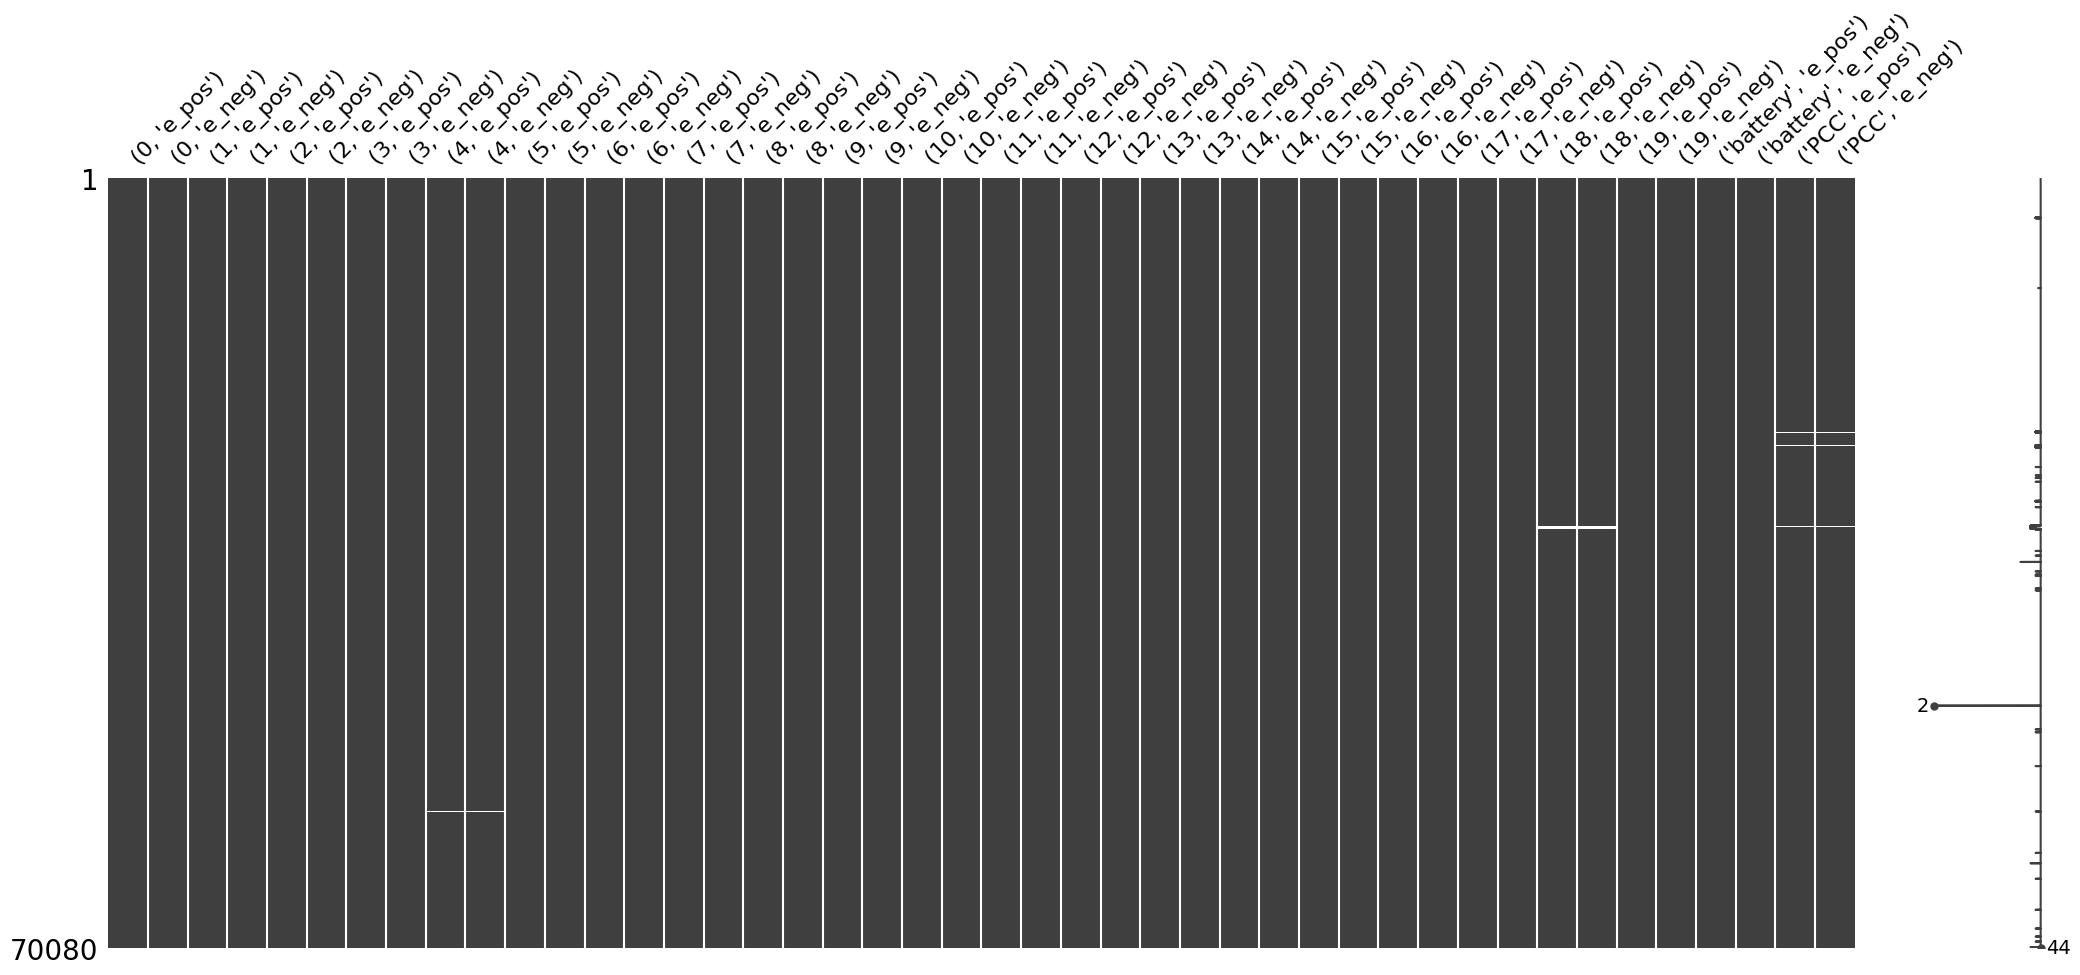

In [23]:
# Visualize the position of null values in the time series of df_meters
msno.matrix(df_meters)

<Axes: >

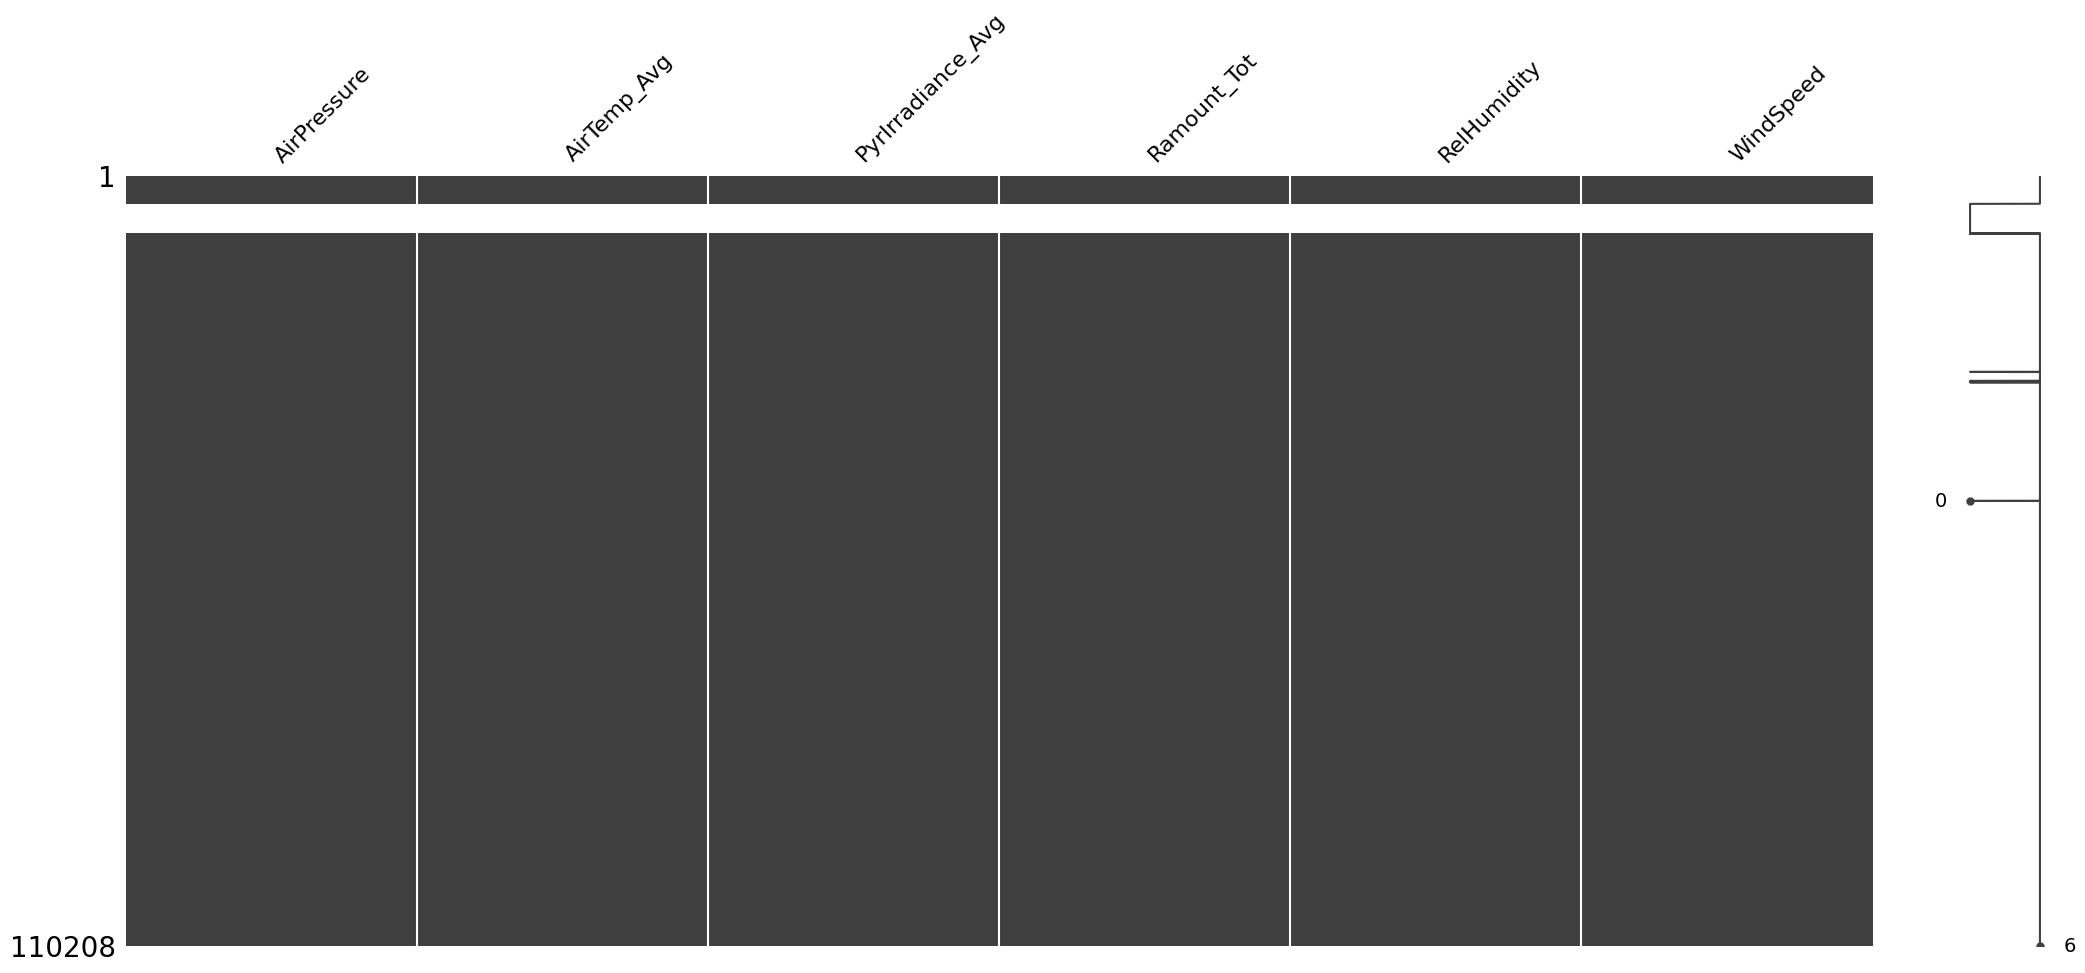

In [24]:
# Visualize the position of null values in the time series of df_meteo
msno.matrix(df_meteo)

<Axes: >

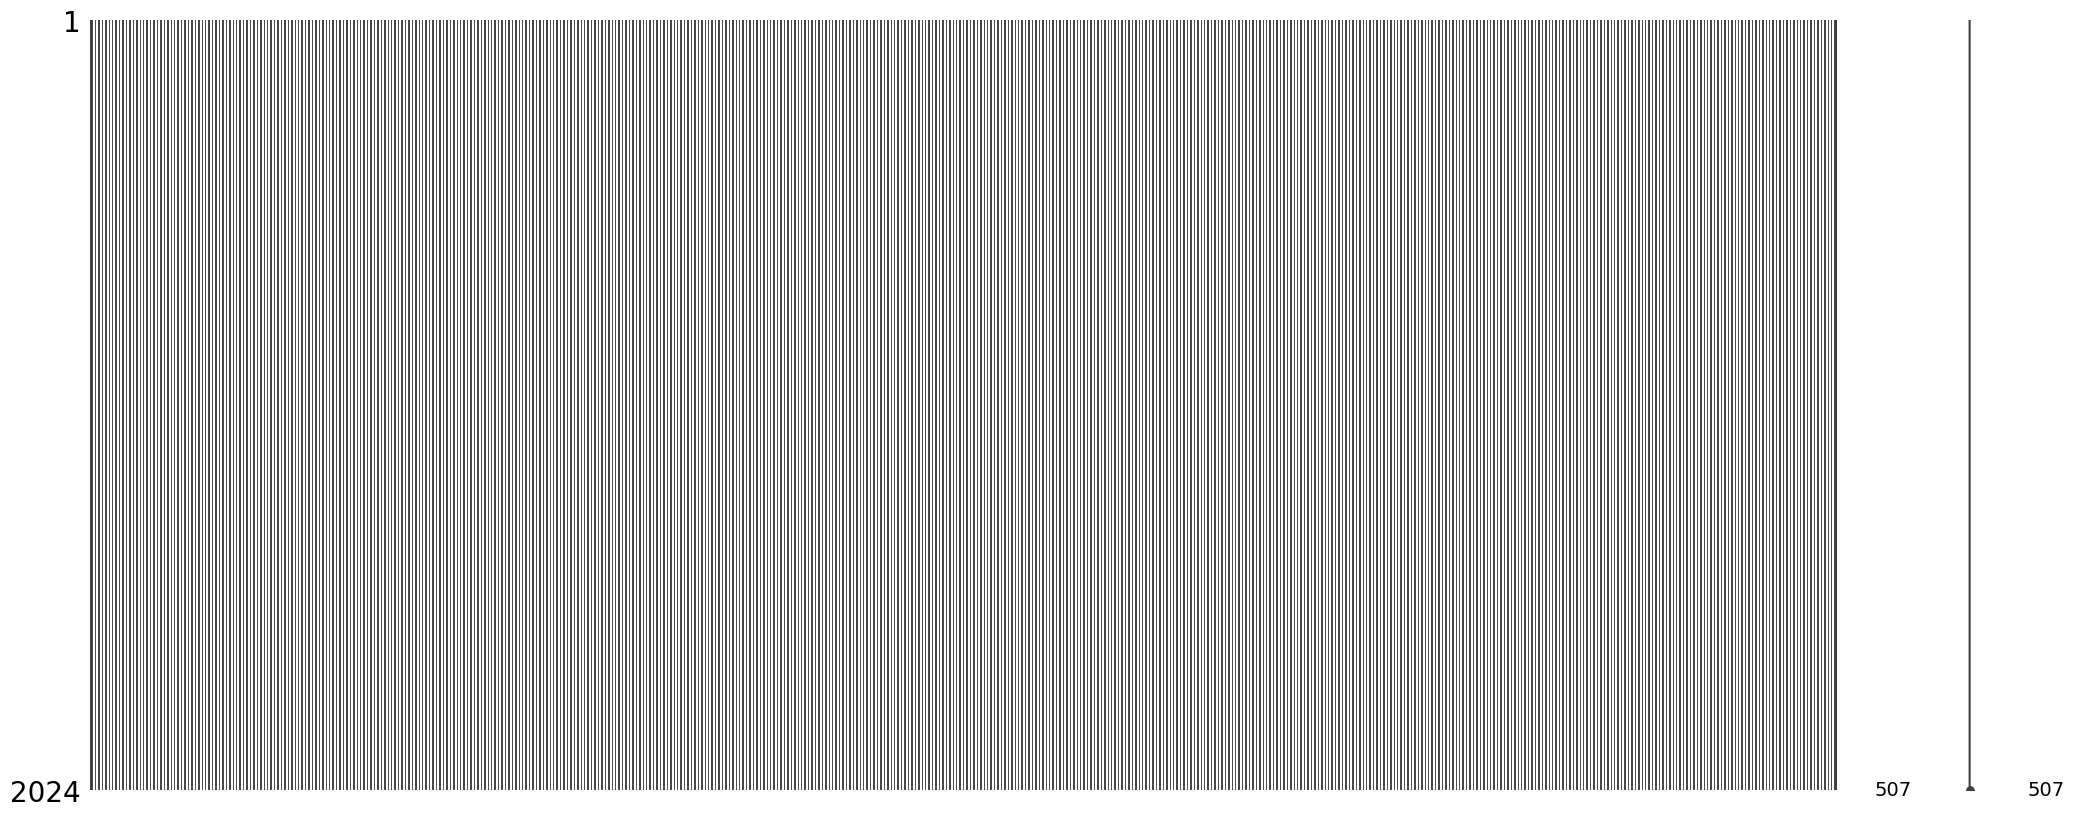

In [25]:
# Visualize the position of null values in the time series of df_nwp
msno.matrix(df_nwp)

## Resample the data at hourly rate

In [26]:
# Check data sampled at 15 minutes intervals
df_meters.head(3)

0            1            2            3        \
                           e_pos e_neg  e_pos e_neg  e_pos e_neg  e_pos e_neg   
2020-12-31 23:00:00+00:00  126.0   0.0  974.0   0.0  544.0   0.0  681.0   0.0   
2020-12-31 23:15:00+00:00  102.0   0.0  211.0   0.0  495.0   0.0  606.0   0.0   
2020-12-31 23:30:00+00:00  121.0   0.0  210.0   0.0  233.0   0.0  598.0   0.0   

                                    4        ...     17           18        \
                                e_pos e_neg  ...  e_pos e_neg  e_pos e_neg   
2020-12-31 23:00:00+00:00  142.000000   0.0  ...  670.0   0.0  808.0   0.0   
2020-12-31 23:15:00+00:00  663.000000   0.0  ...  525.0   0.0  513.0   0.0   
2020-12-31 23:30:00+00:00  437.167377   0.0  ...  499.0   0.0  436.0   0.0   

                               19       battery            PCC        
                            e_pos e_neg   e_pos e_neg    e_pos e_neg  
2020-12-31 23:00:00+00:00  1805.0   0.0     1.0   0.0   9142.0   0.0  
2020-12-31 23:15:00+00:00  3082.0   0.0     0.0   0.0  13330.0   0.0  
2020-12-31 23:30:00+00:00   881.0   0.0     1.0   0.0   9095.0   0.0  

[3 rows x 44 columns]

In [27]:
# Resample the data at hourly rate
df_meteo = df_meteo.resample('H').mean()  # Get average meteo values at hourly rate
df_meters = df_meters.resample('H').sum()  # Sum the measurements of meters to get hourly values
df_nwp = df_nwp.resample('H').interpolate(method='linear')  # Interpolate prediction values to get hourly values

In [28]:
# Check data sampled at 1 hour intervals
df_meters.head(3)

0             1             2             3  \
                           e_pos e_neg   e_pos e_neg   e_pos e_neg   e_pos   
2020-12-31 23:00:00+00:00  447.0   0.0  1686.0   0.0  1721.0   0.0  2509.0   
2021-01-01 00:00:00+00:00  485.0   0.0   810.0   0.0  1862.0   0.0  2469.0   
2021-01-01 01:00:00+00:00  218.0   0.0  1433.0   0.0  1679.0   0.0  2330.0   

                                           4        ...      17            18  \
                          e_neg        e_pos e_neg  ...   e_pos e_neg   e_pos   
2020-12-31 23:00:00+00:00   0.0  1628.982403   0.0  ...  2389.0   0.0  2119.0   
2021-01-01 00:00:00+00:00   0.0  1445.581219   0.0  ...  3317.0   0.0  1984.0   
2021-01-01 01:00:00+00:00   0.0  1317.436378   0.0  ...  3390.0   0.0  1639.0   

                                     19       battery            PCC        
                          e_neg   e_pos e_neg   e_pos e_neg    e_pos e_neg  
2020-12-31 23:00:00+00:00   0.0  6427.0   0.0     3.0   0.0  40947.0   0.0  
2021-01-01 00:00:00+00:00   0.0  6266.0   0.0     2.0   0.0  37873.0   0.0  
2021-01-01 01:00:00+00:00   0.0  7146.0   0.0     3.0   0.0  40145.0   0.0  

[3 rows x 44 columns]

In [29]:
# We slice the data from 2020-12-31 23:00:00+00:00 to the end of the dataset so that it matches the df_meters data
start_date = '2020-12-31 23:00:00+00:00'

end_date = '2022-12-31 22:00:00+00:00'

df_meteo = df_meteo.loc[start_date:end_date]
df_nwp = df_nwp.loc[start_date:end_date]

## Sum up the battery data to the PCC data

In [30]:
# Check PCC data
df_meters['PCC'].head(3)

,e_pos,e_neg
2020-12-31 23:00:00+00:00,40947.0,0.0
2021-01-01 00:00:00+00:00,37873.0,0.0
2021-01-01 01:00:00+00:00,40145.0,0.0


In [31]:
# Check battery data
df_meters['battery'].head(3)

,e_pos,e_neg
2020-12-31 23:00:00+00:00,3.0,0.0
2021-01-01 00:00:00+00:00,2.0,0.0
2021-01-01 01:00:00+00:00,3.0,0.0


In [32]:
# Duplicate the column PCC to then sum it up with the battery data
new_columns = pd.DataFrame(df_meters['PCC'].values, index=df_meters['PCC'].index, 
                           columns=[('PCC_batt', 'e_pos'), ('PCC_batt', 'e_neg')])
df_meters = pd.concat([df_meters, new_columns], axis=1)



In [33]:
# Check if the new 'PCC_batt' column was added
df_meters.columns[-5]


('battery', 'e_neg')

In [34]:
# Fortunately the data is aligned, so we can simply sum the features
# Sum up battery and PCC data
df_meters[('PCC_batt', 'e_pos')] += df_meters[('battery', 'e_pos')]
df_meters[('PCC_batt', 'e_neg')] += df_meters[('battery', 'e_neg')]

In [35]:
 # Check that the sum was successful
df_meters[['PCC', 'battery', 'PCC_batt']].head(3)

# We'll keep the old columns 'PCC' and 'battery' in case we'll need them later

PCC       battery       PCC_batt      
                             e_pos e_neg   e_pos e_neg    e_pos e_neg
2020-12-31 23:00:00+00:00  40947.0   0.0     3.0   0.0  40950.0   0.0
2021-01-01 00:00:00+00:00  37873.0   0.0     2.0   0.0  37875.0   0.0
2021-01-01 01:00:00+00:00  40145.0   0.0     3.0   0.0  40148.0   0.0

## Impute the missing values on df_meters

In [36]:
# Check for nulls in the datasets
print('df_meters:\n', df_meters.isna().sum().sum(), '\n---------\n')

print('df_meteo:\n', df_meteo.isna().sum().sum(), '\n---------\n')

print('df_nwp:\n', df_nwp.isna().sum().sum(), '\n---------\n')

df_meters:
 0 
---------

df_meteo:
 0 
---------

df_nwp:
 0 
---------



<Axes: >

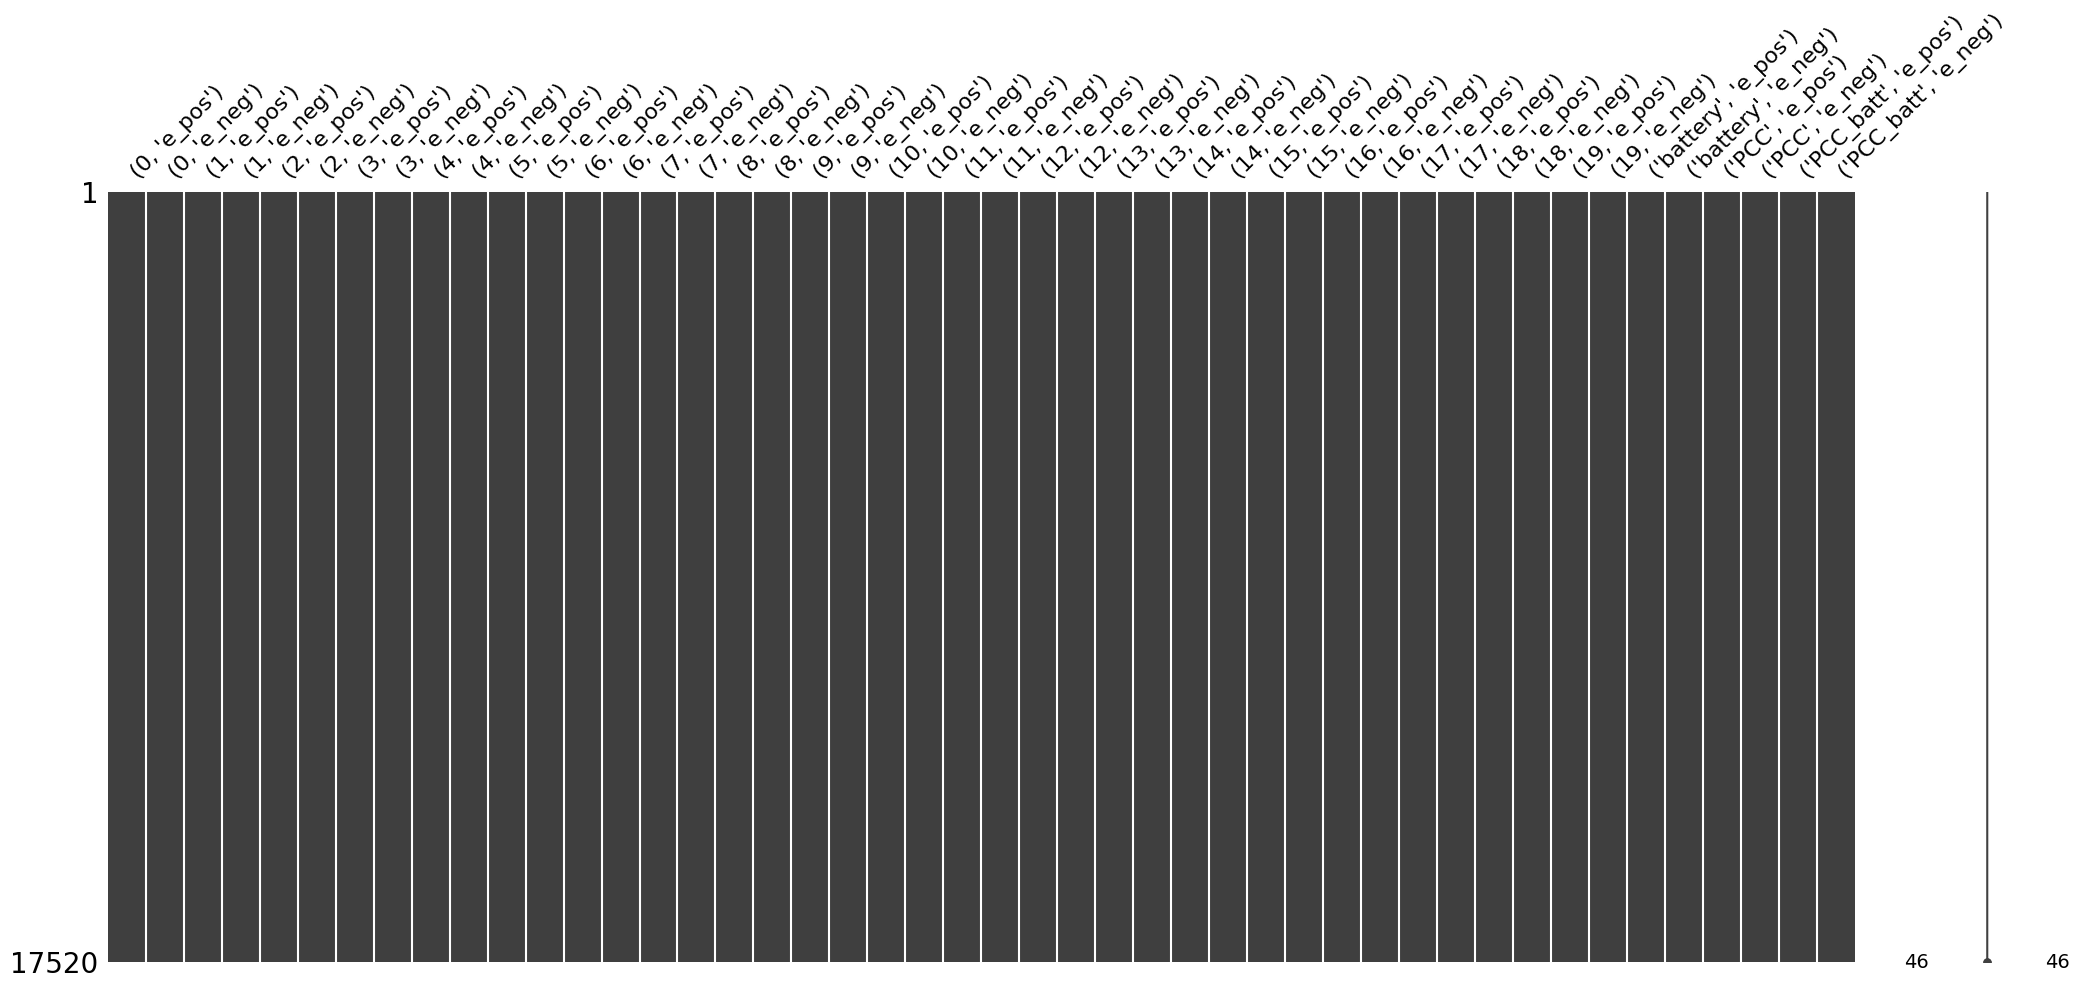

In [37]:
# Visualize the position of the missing values 
msno.matrix(df_meters)

In [38]:
# Impute missing values with the mean
print('Nulls before numerical features imputation:', df_meters.isna().sum().sum())

df_meters = df_meters.fillna(df_meters.mean())

print('Nulls after numerical features imputation:', df_meters.isna().sum().sum())

Nulls before numerical features imputation: 0
Nulls after numerical features imputation: 0


## Get columns e_pos and e_neg containing the concatenatenated values of all the stations

In [39]:
df_new = pd.DataFrame()

trial = df_meters.copy()

trial.reset_index(inplace=True)
trial.rename(columns={'index': 'date'}, inplace=True)

for i in range(20):
    if i == 0:
        df_new[f'e_pos'] = trial[i]['e_pos']
        df_new[f'e_neg'] = trial[i]['e_neg']
        df_new['unique_id'] = i
        df_new['ds'] = trial['date']
    else:
        df_loop = pd.DataFrame()
        df_loop[f'e_pos'] = trial[i]['e_pos']
        df_loop[f'e_neg'] = trial[i]['e_neg']
        df_loop['unique_id'] = i
        df_loop['ds'] = trial['date']
        df_new = pd.concat([df_new, df_loop], axis=0)

df_new.reset_index(drop=True, inplace=True)
# df_new[df_new['unique_id'] == 1]
df_new.unique_id.unique()

e_pos_series = df_new['e_pos']
e_neg_series = df_new['e_neg']

## Remove the multi index

It is not very intuitive to work with a multi-index dataframe, so we'll convert it to a single index dataframe

In [40]:
# Check initial state of df_meters
df_meters.head(1)

0             1             2             3  \
                           e_pos e_neg   e_pos e_neg   e_pos e_neg   e_pos   
2020-12-31 23:00:00+00:00  447.0   0.0  1686.0   0.0  1721.0   0.0  2509.0   

                                           4        ...      18            19  \
                          e_neg        e_pos e_neg  ...   e_pos e_neg   e_pos   
2020-12-31 23:00:00+00:00   0.0  1628.982403   0.0  ...  2119.0   0.0  6427.0   

                                battery            PCC       PCC_batt        
                          e_neg   e_pos e_neg    e_pos e_neg    e_pos e_neg  
2020-12-31 23:00:00+00:00   0.0     3.0   0.0  40947.0   0.0  40950.0   0.0  

[1 rows x 46 columns]

In [41]:
# Check initial state of df_nwp
df_nwp.head(1)

ghi_backwards                                      \
                                    0    1          10   100  101  102  103   
2020-12-31 23:00:00+00:00           0.0  0.0  74.371667  0.0  0.0  0.0  0.0   

                                                           ... temperature  \
                               104        105         106  ...         90    
2020-12-31 23:00:00+00:00  27.4375  126.57875  220.273333  ...    2.904583   

                                                                         \
                             91        92       93        94        95    
2020-12-31 23:00:00+00:00  2.415  1.894167  1.35375  0.899583  0.459167   

                                                                  
                               96        97        98        99   
2020-12-31 23:00:00+00:00 -0.15125 -0.737083 -0.980417 -0.842917  

[1 rows x 507 columns]

In [42]:
# Remove the multi index from df_meters and df_nwp
# df_nwp already has no multi index
df_meters.columns = [f'{col[1]}_{col[0]}' for col in df_meters.columns]
df_nwp.columns = [f'{col[1]}_{col[0]}' for col in df_nwp.columns]

In [43]:
# Check result on df_meters
df_meters.head(1)

,e_pos_0,e_neg_0,e_pos_1,e_neg_1,e_pos_2,e_neg_2,e_pos_3,e_neg_3,e_pos_4,e_neg_4,...,e_pos_18,e_neg_18,e_pos_19,e_neg_19,e_pos_battery,e_neg_battery,e_pos_PCC,e_neg_PCC,e_pos_PCC_batt,e_neg_PCC_batt
2020-12-31 23:00:00+00:00,447.0,0.0,1686.0,0.0,1721.0,0.0,2509.0,0.0,1628.982403,0.0,...,2119.0,0.0,6427.0,0.0,3.0,0.0,40947.0,0.0,40950.0,0.0


In [44]:
# Check result on df_nwp
df_nwp.head(1)

,0_ghi_backwards,1_ghi_backwards,10_ghi_backwards,100_ghi_backwards,101_ghi_backwards,102_ghi_backwards,103_ghi_backwards,104_ghi_backwards,105_ghi_backwards,106_ghi_backwards,...,90_temperature,91_temperature,92_temperature,93_temperature,94_temperature,95_temperature,96_temperature,97_temperature,98_temperature,99_temperature
2020-12-31 23:00:00+00:00,0.0,0.0,74.371667,0.0,0.0,0.0,0.0,27.4375,126.57875,220.273333,...,2.904583,2.415,1.894167,1.35375,0.899583,0.459167,-0.15125,-0.737083,-0.980417,-0.842917


## Merge the datasets to get a single dataset with all the features
Some data has different time windows, so there will be some NaN values.
We decided to drop the windows where we don't have data from all the features.

In [45]:
# Check the range of dates in the three datasets
print('Start date:\n',
      'df_meters:', df_meters.index.min(), '\n',
      'df_meteo:', df_meteo.index.min(), '\n',
      'df_nwp:', df_nwp.index.min(), '\n')
      
print('End date:\n',
      'df_meters:', df_meters.index.max(), '\n',
      'df_meteo:', df_meteo.index.max(), '\n',
      'df_nwp:', df_nwp.index.max())

Start date:
 df_meters: 2020-12-31 23:00:00+00:00 
 df_meteo: 2020-12-31 23:00:00+00:00 
 df_nwp: 2020-12-31 23:00:00+00:00 

End date:
 df_meters: 2022-12-31 22:00:00+00:00 
 df_meteo: 2022-12-31 22:00:00+00:00 
 df_nwp: 2022-12-31 22:00:00+00:00


In [46]:
df = pd.concat([df_meters, df_meteo, df_nwp], axis=1)

In [47]:
df.shape

(17520, 559)

In [48]:
df.head(3)

,e_pos_0,e_neg_0,e_pos_1,e_neg_1,e_pos_2,e_neg_2,e_pos_3,e_neg_3,e_pos_4,e_neg_4,...,90_temperature,91_temperature,92_temperature,93_temperature,94_temperature,95_temperature,96_temperature,97_temperature,98_temperature,99_temperature
2020-12-31 23:00:00+00:00,447.0,0.0,1686.0,0.0,1721.0,0.0,2509.0,0.0,1628.982403,0.0,...,2.904583,2.4150,1.894167,1.353750,0.899583,0.459167,-0.151250,-0.737083,-0.980417,-0.842917
2021-01-01 00:00:00+00:00,485.0,0.0,810.0,0.0,1862.0,0.0,2469.0,0.0,1445.581219,0.0,...,2.910000,2.4200,1.900000,1.360000,0.910000,0.450000,-0.190000,-0.810000,-1.060000,-0.920000
2021-01-01 01:00:00+00:00,218.0,0.0,1433.0,0.0,1679.0,0.0,2330.0,0.0,1317.436378,0.0,...,2.850000,2.3425,1.814167,1.270417,0.819583,0.362917,-0.262083,-0.865417,-1.114167,-0.988750


## Add station column 

Add station column to identify stations' values when values are concatenated

In [49]:
df.reset_index(inplace=True)


df.rename(columns={'index': 'Date'}, inplace = True)
df.head()

,Date,e_pos_0,e_neg_0,e_pos_1,e_neg_1,e_pos_2,e_neg_2,e_pos_3,e_neg_3,e_pos_4,...,90_temperature,91_temperature,92_temperature,93_temperature,94_temperature,95_temperature,96_temperature,97_temperature,98_temperature,99_temperature
0,2020-12-31 23:00:00+00:00,447.0,0.0,1686.0,0.0,1721.0,0.0,2509.0,0.0,1628.982403,...,2.904583,2.4150,1.894167,1.353750,0.899583,0.459167,-0.151250,-0.737083,-0.980417,-0.842917
1,2021-01-01 00:00:00+00:00,485.0,0.0,810.0,0.0,1862.0,0.0,2469.0,0.0,1445.581219,...,2.910000,2.4200,1.900000,1.360000,0.910000,0.450000,-0.190000,-0.810000,-1.060000,-0.920000
2,2021-01-01 01:00:00+00:00,218.0,0.0,1433.0,0.0,1679.0,0.0,2330.0,0.0,1317.436378,...,2.850000,2.3425,1.814167,1.270417,0.819583,0.362917,-0.262083,-0.865417,-1.114167,-0.988750
3,2021-01-01 02:00:00+00:00,224.0,0.0,2046.0,0.0,1749.0,0.0,2457.0,0.0,1185.000000,...,2.790000,2.2650,1.728333,1.180833,0.729167,0.275833,-0.334167,-0.920833,-1.168333,-1.057500
4,2021-01-01 03:00:00+00:00,287.0,0.0,1688.0,0.0,1879.0,0.0,2123.0,0.0,558.000000,...,2.730000,2.1875,1.642500,1.091250,0.638750,0.188750,-0.406250,-0.976250,-1.222500,-1.126250


In [50]:
# Add the station_id column and replicate the dataset 20 times
num_stations = 20
dim = df.shape[0]

# Replicate the rows of the original dataframe by the number of stations
df = pd.concat([df]*num_stations, ignore_index=True)

# Create a list of station IDs
station_ids = []
for i in range(num_stations):
    station_ids += [str(i)]*dim

# Assign the station IDs to the replicated dataframe
df['station_id'] = station_ids


In [51]:
# Concatenate the e_pos_N and e_neg_N columns into the columns e_pos and e_neg
df['e_pos'] = e_pos_series
df['e_neg'] = e_neg_series
df

,Date,e_pos_0,e_neg_0,e_pos_1,e_neg_1,e_pos_2,e_neg_2,e_pos_3,e_neg_3,e_pos_4,...,93_temperature,94_temperature,95_temperature,96_temperature,97_temperature,98_temperature,99_temperature,station_id,e_pos,e_neg
0,2020-12-31 23:00:00+00:00,447.0,0.0,1686.0,0.0,1721.0,0.0,2509.0,0.0,1628.982403,...,1.353750,0.899583,0.459167,-0.151250,-0.737083,-0.980417,-0.842917,0,447.0,0.0
1,2021-01-01 00:00:00+00:00,485.0,0.0,810.0,0.0,1862.0,0.0,2469.0,0.0,1445.581219,...,1.360000,0.910000,0.450000,-0.190000,-0.810000,-1.060000,-0.920000,0,485.0,0.0
2,2021-01-01 01:00:00+00:00,218.0,0.0,1433.0,0.0,1679.0,0.0,2330.0,0.0,1317.436378,...,1.270417,0.819583,0.362917,-0.262083,-0.865417,-1.114167,-0.988750,0,218.0,0.0
3,2021-01-01 02:00:00+00:00,224.0,0.0,2046.0,0.0,1749.0,0.0,2457.0,0.0,1185.000000,...,1.180833,0.729167,0.275833,-0.334167,-0.920833,-1.168333,-1.057500,0,224.0,0.0
4,2021-01-01 03:00:00+00:00,287.0,0.0,1688.0,0.0,1879.0,0.0,2123.0,0.0,558.000000,...,1.091250,0.638750,0.188750,-0.406250,-0.976250,-1.222500,-1.126250,0,287.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350395,2022-12-31 18:00:00+00:00,1038.0,0.0,2514.0,0.0,1513.0,0.0,2613.0,0.0,4762.000000,...,6.277250,6.046250,5.767375,5.450000,5.118500,4.874500,4.801750,19,5441.0,0.0
350396,2022-12-31 19:00:00+00:00,549.0,0.0,355.0,0.0,844.0,0.0,3123.0,0.0,1696.000000,...,6.257208,6.026042,5.746729,5.428333,5.095750,4.851083,4.778292,19,7835.0,0.0
350397,2022-12-31 20:00:00+00:00,1045.0,0.0,362.0,0.0,960.0,0.0,2364.0,0.0,1802.000000,...,6.237167,6.005833,5.726083,5.406667,5.073000,4.827667,4.754833,19,5870.0,0.0
350398,2022-12-31 21:00:00+00:00,426.0,0.0,395.0,0.0,776.0,0.0,1832.0,0.0,809.000000,...,6.217125,5.985625,5.705438,5.385000,5.050250,4.804250,4.731375,19,5396.0,0.0


In [52]:
# Drop all the old e_pos_N and e_neg_N features
df = df.drop(columns=[f'e_pos_{i}' for i in range(20)], axis=1)
df = df.drop(columns=[f'e_neg_{i}' for i in range(20)], axis=1)
df

,Date,e_pos_battery,e_neg_battery,e_pos_PCC,e_neg_PCC,e_pos_PCC_batt,e_neg_PCC_batt,AirPressure,AirTemp_Avg,PyrIrradiance_Avg,...,93_temperature,94_temperature,95_temperature,96_temperature,97_temperature,98_temperature,99_temperature,station_id,e_pos,e_neg
0,2020-12-31 23:00:00+00:00,3.0,0.0,40947.0,0.0,40950.0,0.0,946.013444,0.960222,-0.509756,...,1.353750,0.899583,0.459167,-0.151250,-0.737083,-0.980417,-0.842917,0,447.0,0.0
1,2021-01-01 00:00:00+00:00,2.0,0.0,37873.0,0.0,37875.0,0.0,945.905722,0.788833,-0.375317,...,1.360000,0.910000,0.450000,-0.190000,-0.810000,-1.060000,-0.920000,0,485.0,0.0
2,2021-01-01 01:00:00+00:00,3.0,0.0,40145.0,0.0,40148.0,0.0,946.249667,0.791278,-0.553497,...,1.270417,0.819583,0.362917,-0.262083,-0.865417,-1.114167,-0.988750,0,218.0,0.0
3,2021-01-01 02:00:00+00:00,2.0,0.0,35965.0,0.0,35967.0,0.0,946.063833,0.608611,-0.514245,...,1.180833,0.729167,0.275833,-0.334167,-0.920833,-1.168333,-1.057500,0,224.0,0.0
4,2021-01-01 03:00:00+00:00,3.0,0.0,37186.0,0.0,37189.0,0.0,945.764611,0.544500,-0.395127,...,1.091250,0.638750,0.188750,-0.406250,-0.976250,-1.222500,-1.126250,0,287.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350395,2022-12-31 18:00:00+00:00,121.0,0.0,41276.0,0.0,41397.0,0.0,967.035444,8.178611,-0.436037,...,6.277250,6.046250,5.767375,5.450000,5.118500,4.874500,4.801750,19,5441.0,0.0
350396,2022-12-31 19:00:00+00:00,121.0,0.0,44083.0,0.0,44204.0,0.0,967.583556,7.075167,-0.770346,...,6.257208,6.026042,5.746729,5.428333,5.095750,4.851083,4.778292,19,7835.0,0.0
350397,2022-12-31 20:00:00+00:00,132.0,0.0,32092.0,0.0,32224.0,0.0,967.663611,7.255611,-0.469420,...,6.237167,6.005833,5.726083,5.406667,5.073000,4.827667,4.754833,19,5870.0,0.0
350398,2022-12-31 21:00:00+00:00,136.0,0.0,27325.0,0.0,27461.0,0.0,967.628444,7.260667,-0.308267,...,6.217125,5.985625,5.705438,5.385000,5.050250,4.804250,4.731375,19,5396.0,0.0


## Standardize the data

In [54]:
df_tr = ...
df_te = ...

# Compute standard deviation and mean of each feature
stds = {uid: df_tr.query('unique_id == @uid')['y'].std() for uid in uids}
means = {uid: df_tr.query('unique_id == @uid')['y'].mean() for uid in uids}


NameError: name 'uids' is not defined

In [ ]:
for uid in uids:
    y = (df_tr.loc[df_tr['unique_id'] == uid, 'y'] - means[uid])/stds[uid]
    df_tr.loc[df_tr['unique_id'] == uid, 'y'] = y - y.min()
    df_te.loc[df_te['unique_id'] == uid, 'y_test'] = (df_te.loc[df_te['unique_id'] == uid, 'y_test'] - means[uid])/stds[uid]- y.min()

# Feature Selection (if needed)

# Models building

- It is a good idea to train one model for the prediction on the data in ec_meters and another model for PCC as it has a different scale. Otherwise, 21 model (20 stations + PCC) could be made, but it is unnecessary and time consuming.
- Add some base line models

In [ ]:
# Define the LinearForecaster model
class LinearForecaster:
    def __init__(self):
        self.theta = None
        self.target_cols = None

    def fit(self, X, y):
        self.target_cols = y.columns
        self.theta = np.linalg.pinv(X.values.T@X.values)@(X.values.T@y.values)
        return self
    
    def predict(self, X):
        preds = X.values @ self.theta
        return pd.DataFrame(preds, index=X.index, columns=self.target_cols)       

In [ ]:
def get_hankel(df, embedding=3):
    dfs = {}
    for c in df.columns:
        df_i = pd.concat([df[[c]].shift(-l) for l in range(embedding)], axis=1).iloc[:-embedding]
        df_i.columns = [i for i in range(df_i.shape[1])]
        dfs[c] = df_i
    return pd.concat(dfs, axis=1)

In [ ]:
df_trial = pd.DataFrame()
df_trial['e_pos'] = df[(0, 'e_pos')]
# df_trial.index.names = ['datetime']
df_trial.head()

In [ ]:
# Compute training and testing sets

train_period = 24*5  # Train on 5 days
tr_ratio = 0.75

forecast_periods = [train_period-i for i in range(1, 25)]
period_name = ['1h', '2h', '3h', '4h', '5h', '6h', '7h', '8h', '9h', '10h', '11h', '12h', '13h', '14h', '15h', '16h', '17h', '18h', '19h', '20h', '21h', '22h', '23h', '24h']

train_test_splits = {}

for f_period_name, forecast_period in zip(period_name, forecast_periods):
    # print(f'Forecast period: {f_period_name}')
    # print(f'Forecast period length: {forecast_period} hours')
    df_emb = get_hankel(df_trial, embedding = train_period)
    x = df_emb.loc[:, df_emb.columns.get_level_values(1) < forecast_period]
    y = df_emb.loc[:, df_emb.columns.get_level_values(1) >= forecast_period]

    n_tr = int(len(x) * tr_ratio)
    X_train, X_test = x.iloc[:n_tr, :], x.iloc[n_tr:, :]
    y_train, y_test = y.iloc[:n_tr, :], y.iloc[n_tr:, :]

    train_test_splits[f'{f_period_name}'] = [X_train, y_train, X_test, y_test]

In [ ]:
# Train multiple Linear regresssion models on the different datasets, and save results
scores = {}
for split_name, train_test in train_test_splits.items():
    # Train a linear regression model
    lr = LinearForecaster()
    lr.fit(train_test[0], train_test[1])
    y_train_pred_lr = lr.predict(train_test[0])
    y_test_pred_lr = lr.predict(train_test[2])

    # List of scores, in order: [RMSE, R2]
    score_string = f'Linear {split_name}'

    scores[score_string] = [mean_squared_error(train_test[3], y_test_pred_lr, squared=False), 
                                        r2_score(train_test[3], y_test_pred_lr)]

    # Print results for the different models
    # print(f'Linear {split_name} scores:')
    # print(f'Training RMSE: {mean_squared_error(train_test[1], y_train_pred_lr, squared=False):.2f}')
    # print(f'Testing RMSE: {scores[f"{score_string}"][0]:.2f}')
    # print(f'Training R2: {r2_score(train_test[1], y_train_pred_lr):.2f}')
    # print(f'Testing R2: {scores[f"{score_string}"][1]:.2f}')
    # print('-'*50, '\n')

In [ ]:
# TODO - terminate the multivariate linear regression model

In [ ]:
df.head()

In [ ]:
# Define embeddings for the different datasets and forecast periods
for f_period_name, forecast_period in forecast_periods.items():
    # Compute training and testing sets
    df_emb = get_hankel(df, embedding = train_period)
    x = df_emb.loc[:, df_emb.columns.get_level_values(1) < forecast_period]
    x["dayminute"] = np.sin((x.index.hour * 60 + x.index.minute) / (1410) * 2 * np.pi - np.pi)/2
    x["dayofyear"] = x.index.dayofyear / 365
    
    y = df_emb.loc[:, df_emb.columns.get_level_values(1) >= forecast_period]['PM10']

    n_tr = int(len(x) * tr_ratio)
    X_train, X_test = x.iloc[:n_tr, :], x.iloc[n_tr:, :]
    y_train, y_test = y.iloc[:n_tr, :], y.iloc[n_tr:, :]

    train_test_splits[f'{df_name} {f_period_name}'] = [X_train, y_train, X_test, y_test]

# Model selection

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Preprocess the data
# You can apply any additional preprocessing steps based on your dataset's requirements
scaler = StandardScaler()
scaled_df = df.copy()
scaled_df[df.columns.levels[0] == 'general'] = scaler.fit_transform(df[df.columns.levels[0] == 'general'])

# Split the data into training and validation sets
train_df, val_df = train_test_split(scaled_df, test_size=0.2, shuffle=False, random_state=42)

# Bottom-up hierarchical modeling
# Train individual models for each station's epos and eneg values
models = {}
for station in df.columns.levels[1]:
    for variable in ['epos', 'eneg']:
        X_train = train_df.loc[:, ('general', 'general')].values
        y_train = train_df.loc[:, (slice(None), station, variable)].values.ravel()

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        models[(station, variable)] = model

# Validate the models on the validation set
X_val = val_df.loc[:, ('general', 'general')].values
y_val_true = val_df.loc[:, (slice(None), slice(None), ['epos', 'eneg'])].values.reshape(-1)
y_val_pred = np.zeros_like(y_val_true)

for i, (station, variable) in enumerate(models.keys()):
    model = models[(station, variable)]
    y_val_pred[i::len(models)] = model.predict(X_val)

# Calculate the Mean Absolute Error (MAE)
mae = mean_absolute_error(y_val_true, y_val_pred)
print(f'Mean Absolute Error: {mae:.2f}')
